In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score,KFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, median_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, cv, Pool

In [2]:
data_input=pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/mmc3.csv", sep=',')

In [8]:
data_input

DOI  Pt_wt  Pt_size  Surface_area  N_doped    pH  \
0    10.1021/acsami.6b03924   31.4     5.00         485.0     4.52   0.3   
1    10.1021/acsami.6b03924   31.4     5.00         485.0     4.52   0.3   
2    10.1021/acsami.9b20781   20.3     4.24          36.1     0.00   0.3   
3    10.1021/acsami.9b20781   20.3     4.24          36.1     0.00   0.3   
4    10.1021/acsami.9b20781   20.3     4.24          36.1     0.00  14.0   
..                      ...    ...      ...           ...      ...   ...   
374  10.1021/acsami.6b03924    0.0     0.00         485.0     4.52   0.3   
375  10.1021/acsami.6b03924    0.0     0.00         491.0     7.22   0.3   
376  10.1021/acsami.6b03924    0.0     0.00         491.0     7.22   0.3   
377  10.1021/acsami.6b03924    0.0     0.00         509.0     3.05   0.3   
378  10.1021/acsami.6b03924    0.0     0.00         509.0     3.05   0.3   

     Current_Density  Overpotential  
0                 10           50.0  
1                 20           74.0  
2                 10           18.2  
3                 20           22.0  
4                 10           63.0  
..               ...            ...  
374               20          686.0  
375               10          513.0  
376               20          598.0  
377               10          700.0  
378               20          759.0  

[379 rows x 8 columns]

In [3]:
labels=data_input['Overpotential']
features=data_input.drop('Overpotential', axis=1).drop('DOI', axis=1)

X_train,X_test,y_train,y_test=train_test_split(features, labels, test_size=0.2, random_state=42) #42
scaler = MinMaxScaler(feature_range=(-1, 1))
#scaler = scaler.fit(X_train)
train_set_scaled = scaler.fit_transform(X_train)
test_set_scaled = scaler.transform(X_test)

In [ ]:
[0.001, 0.01, 0.1,1,10]

In [52]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the objective function
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_categorical('n_estimators', [100, 500, 1000, 1500, 2000])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-4, 1e-3, 1e-2, 5e-2, 1e-1])
    max_depth = trial.suggest_categorical('max_depth', [1, 3, 5, 7, 10])
    subsample = trial.suggest_categorical('subsample', [0.5, 0.6, 0.7, 0.8, 0.9])
    colsample_bytree = trial.suggest_categorical('colsample_bytree', [0.5, 0.6, 0.7, 0.8, 1.0])
    reg_lambda = trial.suggest_categorical('reg_lambda', [1e-3, 1e-2, 1e-1, 1, 10])
    reg_alpha = trial.suggest_categorical('reg_alpha', [1e-3, 1e-2, 1e-1, 1, 10])

    # Create the model with the suggested hyperparameters
    xgb_reg = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        objective='reg:squarederror',
        random_state=0,
        eval_metric='rmse',
        early_stopping_rounds=100
    )

    # Fit the model
    xgb_reg.fit(train_set_scaled, y_train, eval_set=[(train_set_scaled, y_train)], verbose=False)
    
    # Predict
    y_pred = xgb_reg.predict(test_set_scaled)
    
    # Evaluate the model
    score = r2_score(y_test, y_pred)
    
    return score

# Create the study
study = optuna.create_study(direction='maximize')

# Optimize the study
study.optimize(objective, n_trials=100)

# Print the best parameters
print("Best parameters:", study.best_params)

# Train the final model using the best parameters
best_params = study.best_params
xgb_reg = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_lambda=best_params['reg_lambda'],
    reg_alpha=best_params['reg_alpha'],
    objective='reg:squarederror',
    random_state=0,
    eval_metric='rmse',
    early_stopping_rounds=100
)

# Fit the final model
xgb_reg.fit(train_set_scaled, y_train, eval_set=[(train_set_scaled, y_train)], verbose=True)

# Predict
y_pred_2 = xgb_reg.predict(train_set_scaled)
y_pred = xgb_reg.predict(test_set_scaled)

# Print the final r2 score
print("Test Accuracy r2: %.4g" % r2_score(y_test, y_pred))


[I 2024-07-27 12:29:46,541] A new study created in memory with name: no-name-abf109f5-01ad-4c6e-9136-f498b29966a7
[I 2024-07-27 12:29:47,149] Trial 0 finished with value: 0.9537768785771105 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.7, 'reg_lambda': 10, 'reg_alpha': 0.001}. Best is trial 0 with value: 0.9537768785771105.
[I 2024-07-27 12:29:48,303] Trial 1 finished with value: -0.31409839737451706 and parameters: {'n_estimators': 2000, 'learning_rate': 0.0001, 'max_depth': 1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_lambda': 1, 'reg_alpha': 1}. Best is trial 0 with value: 0.9537768785771105.
[I 2024-07-27 12:29:48,625] Trial 2 finished with value: -0.5012070672114226 and parameters: {'n_estimators': 100, 'learning_rate': 0.001, 'max_depth': 7, 'subsample': 0.9, 'colsample_bytree': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 10}. Best is trial 0 with value: 0.9537768785771105.
[I 2024-07-27 12:29:49,641] Trial 3 f

Best parameters: {'n_estimators': 1500, 'learning_rate': 0.05, 'max_depth': 7, 'subsample': 0.5, 'colsample_bytree': 1.0, 'reg_lambda': 1, 'reg_alpha': 1}
[0]	validation_0-rmse:156.65366
[1]	validation_0-rmse:150.88906
[2]	validation_0-rmse:144.56306
[3]	validation_0-rmse:139.10547
[4]	validation_0-rmse:133.17309
[5]	validation_0-rmse:128.09945
[6]	validation_0-rmse:123.38687
[7]	validation_0-rmse:118.32118
[8]	validation_0-rmse:114.08651
[9]	validation_0-rmse:109.84515
[10]	validation_0-rmse:105.66357
[11]	validation_0-rmse:102.25805
[12]	validation_0-rmse:98.12518
[13]	validation_0-rmse:94.44779
[14]	validation_0-rmse:91.41688
[15]	validation_0-rmse:87.80340
[16]	validation_0-rmse:85.10002
[17]	validation_0-rmse:81.85753
[18]	validation_0-rmse:78.83161
[19]	validation_0-rmse:75.92243
[20]	validation_0-rmse:73.43071
[21]	validation_0-rmse:71.36938
[22]	validation_0-rmse:69.27243
[23]	validation_0-rmse:67.11882
[24]	validation_0-rmse:64.88242
[25]	validation_0-rmse:63.01094
[26]	valida

In [4]:
#Best parameters: {'n_estimators': 1500, 'learning_rate': 0.05, 'max_depth': 7, 'subsample': 0.5, 'colsample_bytree': 1.0, 'reg_lambda': 1, 'reg_alpha': 1}
xgb_reg = XGBRegressor(
    n_estimators=1500,         
    learning_rate=0.05,       
    max_depth=7,              
    subsample=0.5,             
    colsample_bytree=1.0,      
    reg_lambda=1,             
    reg_alpha=1,               
    objective='reg:squarederror', 
    random_state=0,        )    

# Fit the model
xgb_reg.fit(train_set_scaled, y_train, eval_metric='rmse', verbose=True, eval_set=[(train_set_scaled, y_train)], early_stopping_rounds=100)

/home/kumail/anaconda3/envs/rapids-23.04/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/kumail/anaconda3/envs/rapids-23.04/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:156.65366
[1]	validation_0-rmse:150.88906
[2]	validation_0-rmse:144.56306
[3]	validation_0-rmse:139.10547
[4]	validation_0-rmse:133.17309
[5]	validation_0-rmse:128.09945
[6]	validation_0-rmse:123.38687
[7]	validation_0-rmse:118.32118
[8]	validation_0-rmse:114.08651
[9]	validation_0-rmse:109.84515
[10]	validation_0-rmse:105.66357
[11]	validation_0-rmse:102.25805
[12]	validation_0-rmse:98.12518
[13]	validation_0-rmse:94.44779
[14]	validation_0-rmse:91.41688
[15]	validation_0-rmse:87.80340
[16]	validation_0-rmse:85.10002
[17]	validation_0-rmse:81.85753
[18]	validation_0-rmse:78.83161
[19]	validation_0-rmse:75.92243
[20]	validation_0-rmse:73.43071
[21]	validation_0-rmse:71.36938
[22]	validation_0-rmse:69.27243
[23]	validation_0-rmse:67.11882
[24]	validation_0-rmse:64.88242
[25]	validation_0-rmse:63.01094
[26]	validation_0-rmse:60.95236
[27]	validation_0-rmse:59.03158
[28]	validation_0-rmse:57.30603
[29]	validation_0-rmse:55.40142
[30]	validation_0-rmse:53.82756
[31]	v

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [5]:
y_pred_2 = xgb_reg.predict(train_set_scaled)
y_pred = xgb_reg.predict(test_set_scaled)
                                      
result1=pd.DataFrame(columns=['y_test','y_pred'])
result2=pd.DataFrame(columns=['y_train','y_train_pred'])
result1['y_test']=y_test
result1['y_pred']=y_pred
result2['y_train']=y_train
result2['y_train_pred']=y_pred_2

print("Train Accuracy r2: %.4g" % sk.metrics.r2_score(y_train, y_pred_2))
print("Test Accuracy r2: %.4g" % sk.metrics.r2_score(y_test, y_pred))
print("Train Accuracy MAE: %.4g" % sk.metrics.mean_absolute_error(y_train, y_pred_2))
print("Test Accuracy MAE: %.4g" % sk.metrics.mean_absolute_error(y_test, y_pred))
print("Train Accuracy mse: %.4g" % sk.metrics.mean_squared_error(y_train, y_pred_2))
print("Test Accuracy mse: %.4g" % sk.metrics.mean_squared_error(y_test, y_pred))

Train Accuracy r2: 0.9999
Test Accuracy r2: 0.9811
Train Accuracy MAE: 0.4963
Test Accuracy MAE: 10.84
Train Accuracy mse: 1.37
Test Accuracy mse: 267.7


In [6]:
result1

y_test      y_pred
288   143.5  145.369461
283   146.0  133.474319
327   152.0  154.532166
145    64.5   71.640678
55    144.0  161.175781
..      ...         ...
249    90.0   99.613823
182    77.5   60.867565
317    61.0   56.324371
110    26.0   27.786877
332    62.0   62.721748

[76 rows x 2 columns]

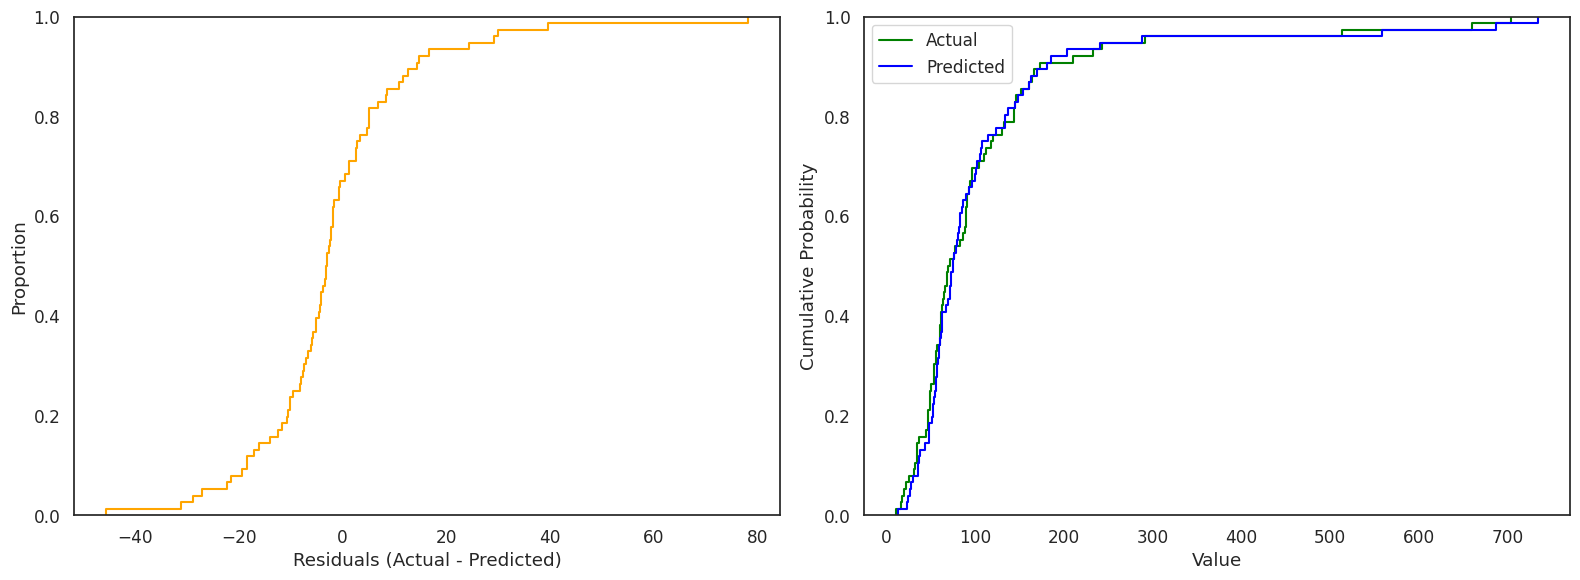

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming result1 DataFrame exists and contains columns: 'y_test', 'y_pred'
result1['residuals'] = result1['y_test'] - result1['y_pred']
result1['abs_residuals'] = result1['residuals'].abs()  # Use absolute values for error bars

# Set up the figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# 1. Cumulative Distribution Function (CDF) Plot of Residuals
sns.ecdfplot(result1['residuals'], color='orange', ax=ax[0])
#ax[0].set_title('CDF of Residuals')
ax[0].set_xlabel('Residuals (Actual - Predicted)')
ax[0].set_ylabel('Proportion')
ax[0].grid(False)  # Remove grid lines from the first subplot

# 2. Cumulative Distribution Function (CDF) Plot for Actual vs Predicted
sns.ecdfplot(result1['y_test'], label='Actual', color='green', ax=ax[1])
sns.ecdfplot(result1['y_pred'], label='Predicted', color='blue', ax=ax[1])
#ax[1].set_title('CDF Plot of Actual vs Predicted')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Cumulative Probability')
ax[1].legend()
ax[1].grid(False)  # Remove grid lines from the second subplot

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('cdf_plots_xgboost.jpg', dpi=900)
plt.show()

/tmp/ipykernel_3623/1882568532.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(result1['residuals'], shade=True, color='orange', ax=ax[1])


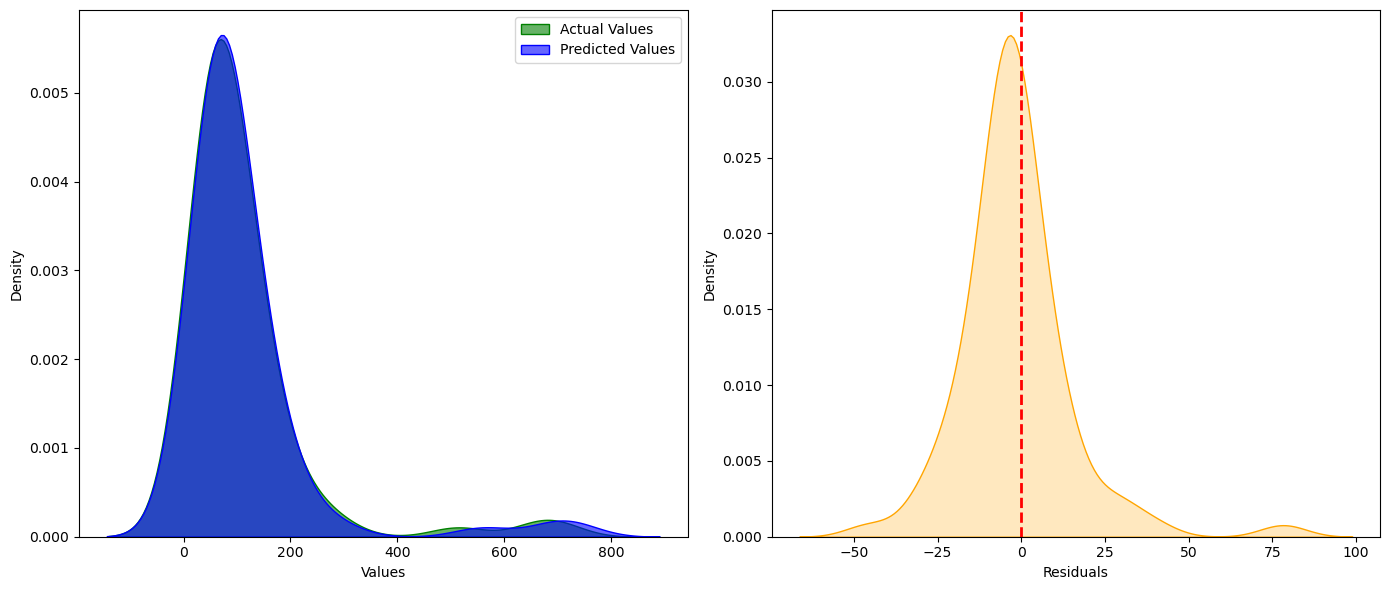

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 1. Density Plot of Actual vs. Predicted Values
sns.kdeplot(result1['y_test'], label='Actual Values', fill=True, color='green', alpha=0.6, ax=ax[0])
sns.kdeplot(result1['y_pred'], label='Predicted Values', fill=True, color='blue', alpha=0.6, ax=ax[0])
ax[0].set_xlabel('Values')
ax[0].set_ylabel('Density')
#ax[0].set_title('Density Plot: Actual vs. Predicted Values')
ax[0].legend()
ax[0].grid(False)  # Remove grid lines from the first subplot

# 2. Prediction Error Distribution Plot
sns.kdeplot(result1['residuals'], shade=True, color='orange', ax=ax[1])
ax[1].axvline(0, color='red', linestyle='--', linewidth=2)
ax[1].set_xlabel('Residuals')
#ax[1].set_title('Prediction Error Distribution')
ax[1].grid(False)  # Remove grid lines from the second subplot

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('Distribution_plots_xgboost.jpg', dpi=900)  # Save with 900 DPI resolution
plt.show()

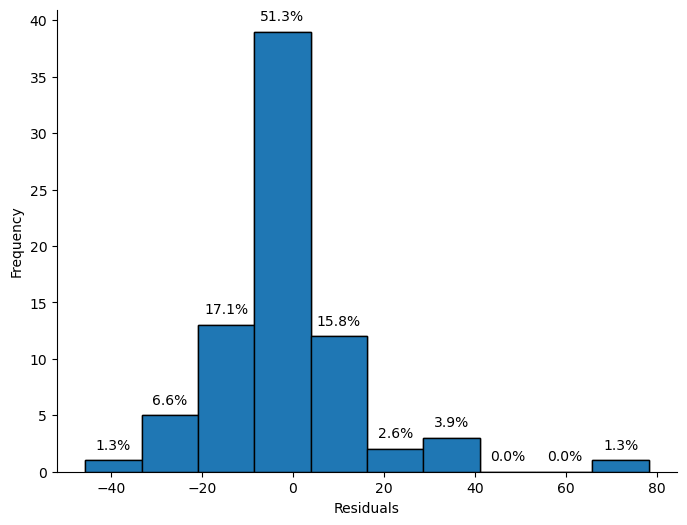

In [12]:
result1['residuals'] = result1['y_test'] - result1['y_pred']

# Plot histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(result1['residuals'], bins=10, edgecolor='black', color='blue')

# Get histogram counts and bin edges
counts, bins, _ = plt.hist(result1['residuals'], bins=10, edgecolor='black')

# Calculate percentages
percentages = [f'{count / len(result1) * 100:.1f}%' for count in counts]

# Annotate each bin with its percentage
for i, count in enumerate(counts):
    plt.text(bins[i] + (bins[i+1] - bins[i]) / 2, count + 1, percentages[i], ha='center')

plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('histogram_residuals_xgboost.pdf')
plt.show()

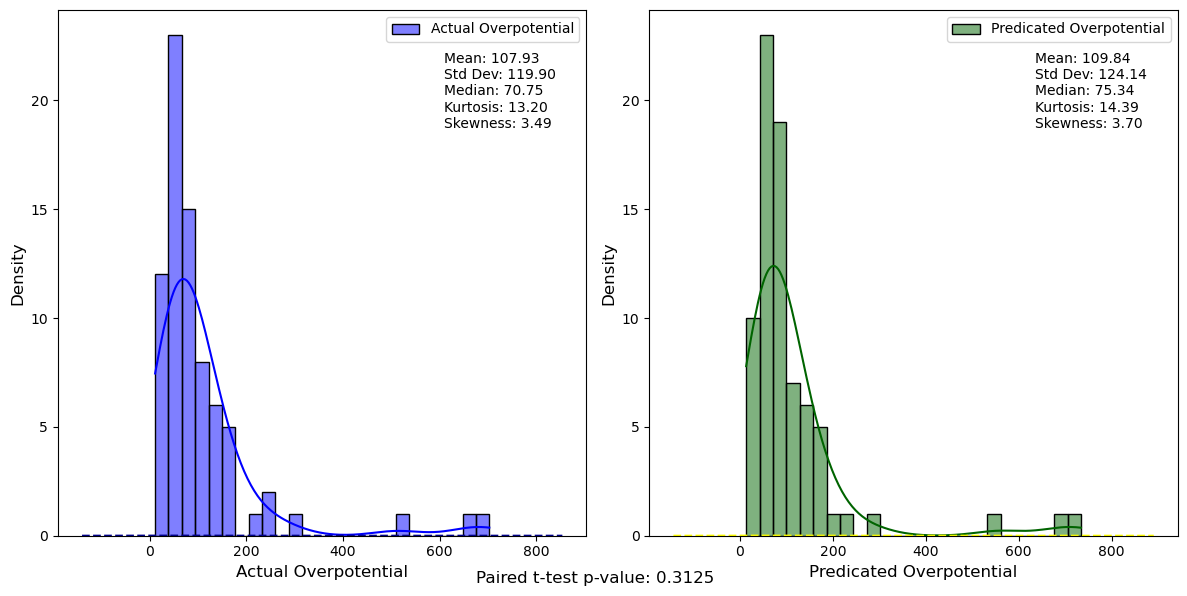

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel, kurtosis, skew

# Calculating statistics
mean_y_test = result1['y_test'].mean()
std_y_test = result1['y_test'].std()
kurt_y_test = kurtosis(result1['y_test'])
skew_y_test = skew(result1['y_test'])
median_y_test = result1['y_test'].median()

mean_y_pred = result1['y_pred'].mean()
std_y_pred = result1['y_pred'].std()
kurt_y_pred = kurtosis(result1['y_pred'])
skew_y_pred = skew(result1['y_pred'])
median_y_pred = result1['y_pred'].median()

# Perform a statistical test (example: paired t-test)
t_stat, p_val = ttest_rel(result1['y_test'], result1['y_pred'])

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Actual Values
sns.histplot(result1['y_test'], bins=25, kde=True, color='blue', ax=axes[0], label='Actual Overpotential')
sns.kdeplot(result1['y_test'], color='darkblue', ax=axes[0], linestyle='--')
axes[0].set_xlabel('Actual Overpotential', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].tick_params(axis='both', which='major', labelsize=10)
axes[0].text(
    0.73, 0.92,
    f'Mean: {mean_y_test:.2f}\nStd Dev: {std_y_test:.2f}\nMedian: {median_y_test:.2f}\nKurtosis: {kurt_y_test:.2f}\nSkewness: {skew_y_test:.2f}',
    transform=axes[0].transAxes,
    fontsize=10,
    verticalalignment='top'
)

# Plot for Predicted Values
sns.histplot(result1['y_pred'], bins=25, kde=True, color='darkgreen', ax=axes[1], label='Predicated Overpotential')
sns.kdeplot(result1['y_pred'], color='yellow', ax=axes[1], linestyle='--')
axes[1].set_xlabel('Predicated Overpotential', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=10)
axes[1].text(
    0.73, 0.92,
    f'Mean: {mean_y_pred:.2f}\nStd Dev: {std_y_pred:.2f} \nMedian: {median_y_pred:.2f}\nKurtosis: {kurt_y_pred:.2f}\nSkewness: {skew_y_pred:.2f}',
    transform=axes[1].transAxes,
    fontsize=10,
    verticalalignment='top'
)

# Add a legend
axes[0].legend()
axes[1].legend()
axes[0].grid(False)
axes[1].grid(False)

# Add statistical test information
fig.text(0.5, 0.02, f'Paired t-test p-value: {p_val:.4f}', ha='center', fontsize=12)
plt.savefig('Distribution of Predicted and Actual Values XGboost.pdf')
plt.tight_layout()
plt.show()

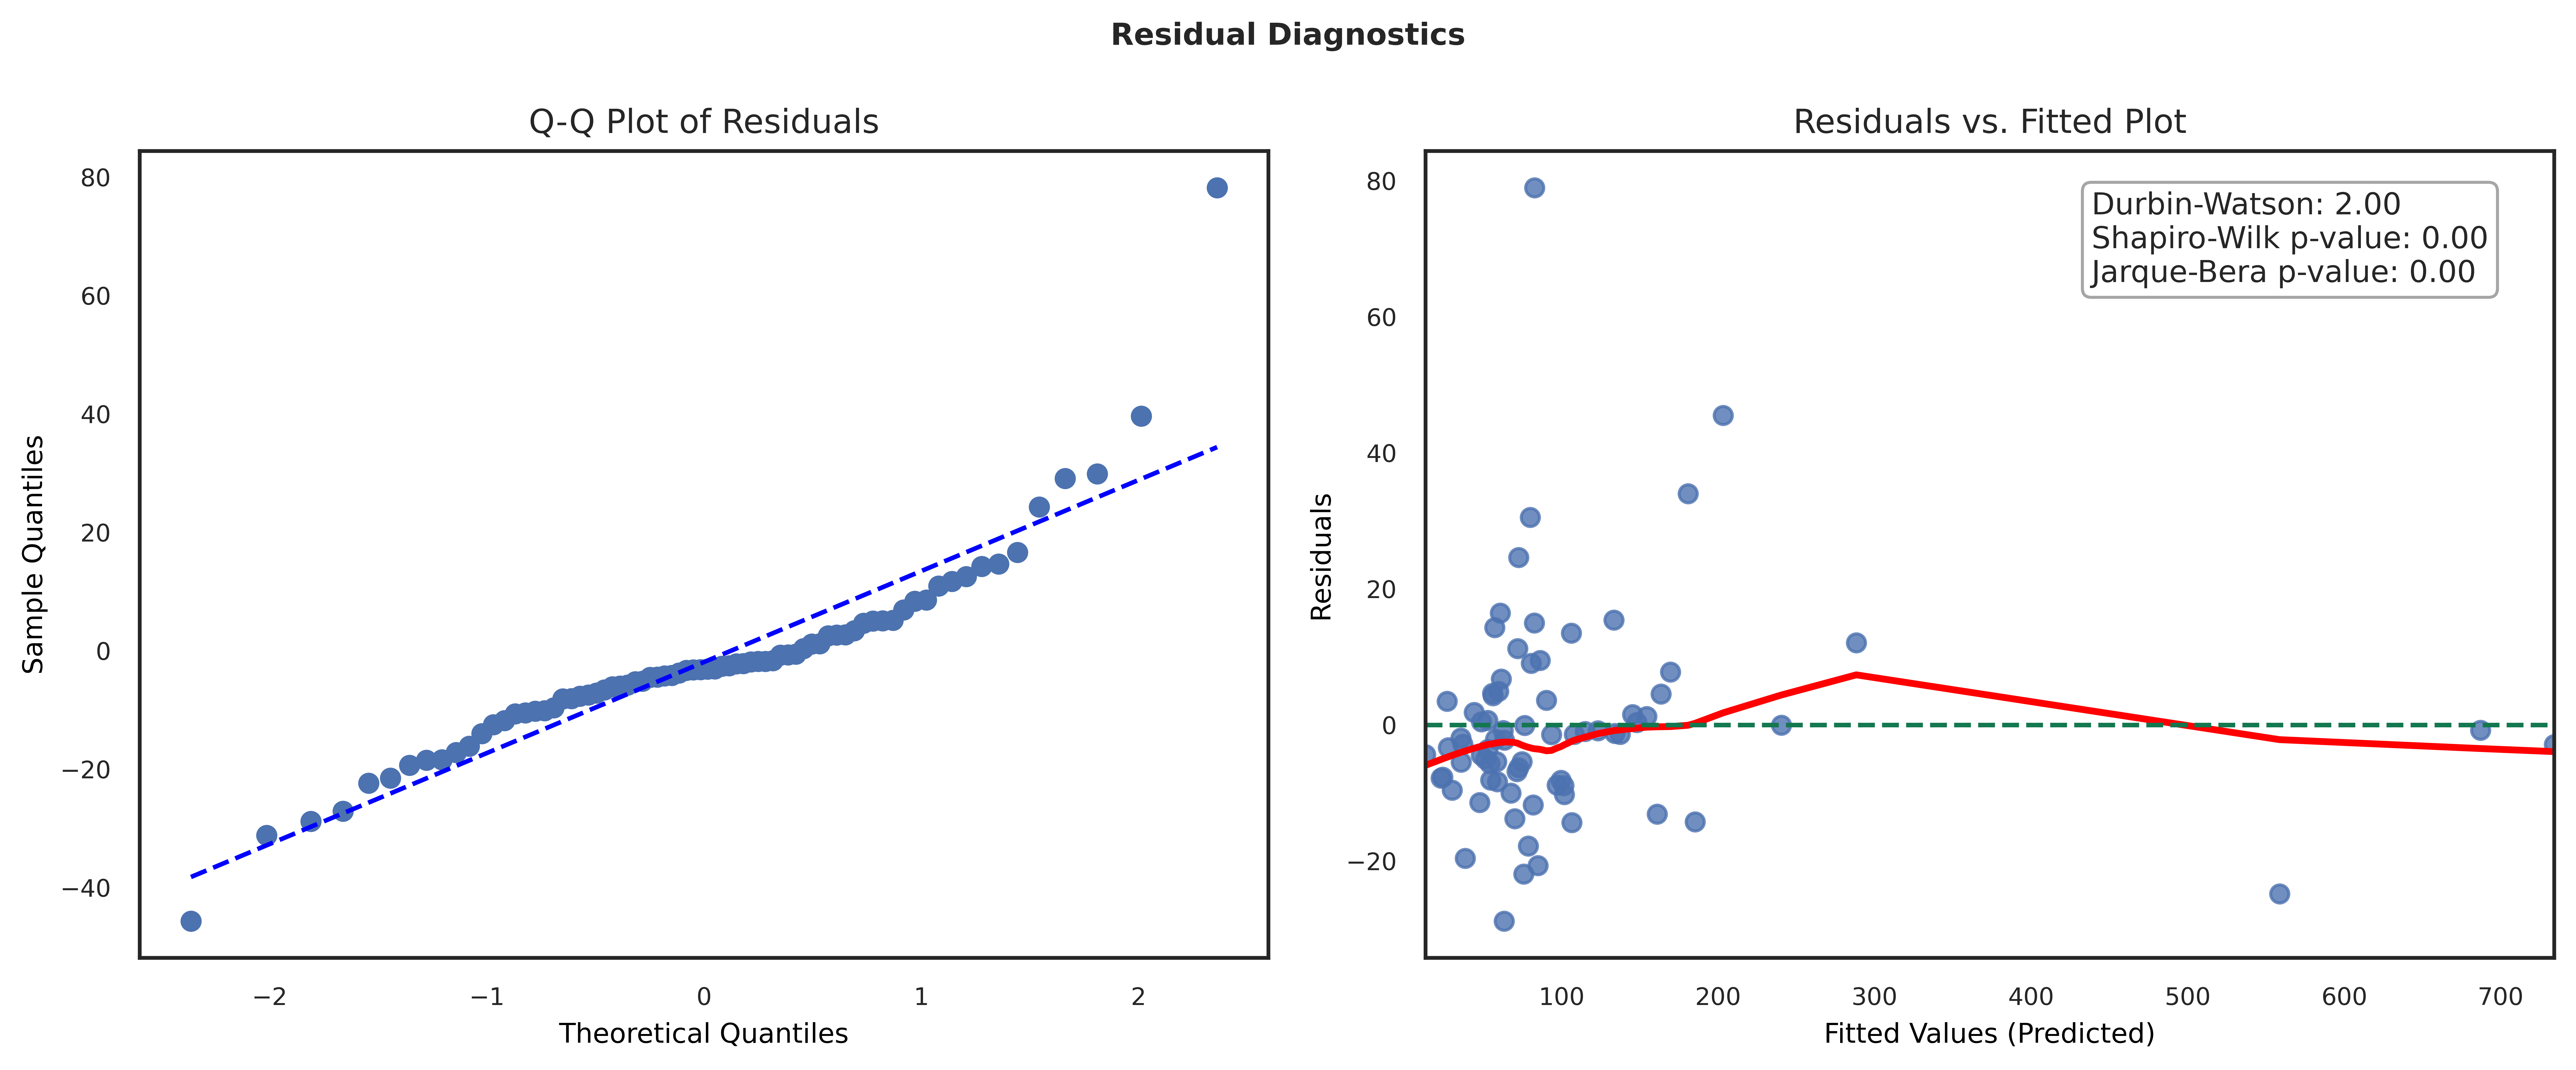

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import pandas as pd

# Example DataFrame (replace with your actual data)
result1['residuals'] = result1['y_test'] - result1['y_pred']


# Calculate Durbin-Watson Statistic
dw_stat = sm.stats.durbin_watson(result1['residuals'])

# Calculate Shapiro-Wilk Test p-value
shapiro_test = stats.shapiro(result1['residuals'])
shapiro_p_value = shapiro_test.pvalue

# Calculate Jarque-Bera Test
jarque_bera_test = stats.jarque_bera(result1['residuals'])
jb_stat, jb_p_value = jarque_bera_test

# Set Seaborn style for better aesthetics
sns.set(style="white")

# Set up the figure and axes with a larger resolution for publication
fig, axs = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True, dpi=900)
fig.suptitle('Residual Diagnostics', fontsize=10, fontweight='bold')

# Q-Q Plot of Residuals
stats.probplot(result1['residuals'], dist="norm", plot=axs[0])
axs[0].set_title('Q-Q Plot of Residuals', fontsize=11)
axs[0].get_lines()[1].set_color('blue')  # Change color of the Q-Q line
axs[0].get_lines()[1].set_linestyle('--') # Change style of the Q-Q line
axs[0].set_xlabel('Theoretical Quantiles', fontsize=9, color='black')  # Bold and clear x-axis label
axs[0].set_ylabel('Sample Quantiles', fontsize=9, color='black')
axs[0].tick_params(axis='both', which='major', labelsize=8)
# Removed grid line from Q-Q Plot

# Residuals vs. Fitted Plot
sns.residplot(x='y_pred', y='residuals', data=result1, lowess=True, line_kws={'color': 'red'}, ax=axs[1])
axs[1].axhline(y=0, color='#137850', linestyle='--')
axs[1].set_title('Residuals vs. Fitted Plot', fontsize=11)
axs[1].set_xlabel('Fitted Values (Predicted)', fontsize=9, color='black')  # Clear x-axis label
axs[1].set_ylabel('Residuals', fontsize=9, color='black')  
axs[1].tick_params(axis='both', which='major', labelsize=8)
# Removed grid line from Residuals vs. Fitted Plot

# Add annotations for statistical tests
textstr = '\n'.join((
    f'Durbin-Watson: {dw_stat:.2f}',
    f'Shapiro-Wilk p-value: {shapiro_p_value:.2f}',
    f'Jarque-Bera p-value: {jb_p_value:.2f}'
))

# Adding text to the Residuals vs. Fitted Plot
axs[1].text(0.59, 0.95, textstr, transform=axs[1].transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.7))

# Save the plot to a file
plt.savefig('XGBoost_residual_diagnostics.pdf')

# Show the combined plot
plt.show()

/home/kumail/anaconda3/envs/rapids-23.04/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray'` for same effect.
  warnings.warn(msg, FutureWarning)


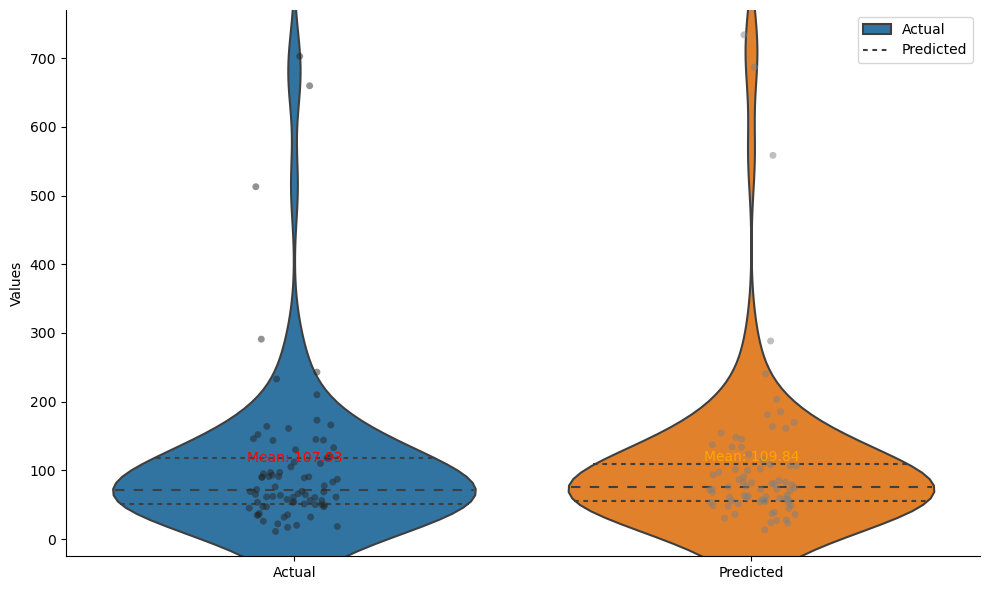

In [14]:
plt.figure(figsize=(10, 6))

# Create violin plot with quartile lines inside
sns.violinplot(data=result1[['y_test', 'y_pred']], inner='quartile')

# Calculate mean values
mean_actual = result1['y_test'].mean()
mean_predicted = result1['y_pred'].mean()

ax = plt.gca()

# Overlay strip plots to show individual data points (optional)
sns.stripplot(data=result1[['y_test', 'y_pred']], color='gray', alpha=0.5)
# Annotate the violin plot with mean values
plt.text(0, mean_actual, f'Mean: {mean_actual:.2f}', ha='center', va='bottom', fontsize=10, color='red')
plt.text(1, mean_predicted, f'Mean: {mean_predicted:.2f}', ha='center', va='bottom', fontsize=10, color='orange')
# Set labels and title
plt.ylabel('Values')
plt.xticks(ticks=[0, 1], labels=['Actual', 'Predicted'])
#plt.title('Distribution of Actual vs. Predicted Values')

# Add legend (if needed)
plt.legend(['Actual', 'Predicted'], loc='upper right')
plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.legend(fontsize=10)

plt.savefig('violinplot Distribution of Actual vs. Predicted Values XGBoost.pdf')
plt.show()

<Figure size 800x800 with 0 Axes>

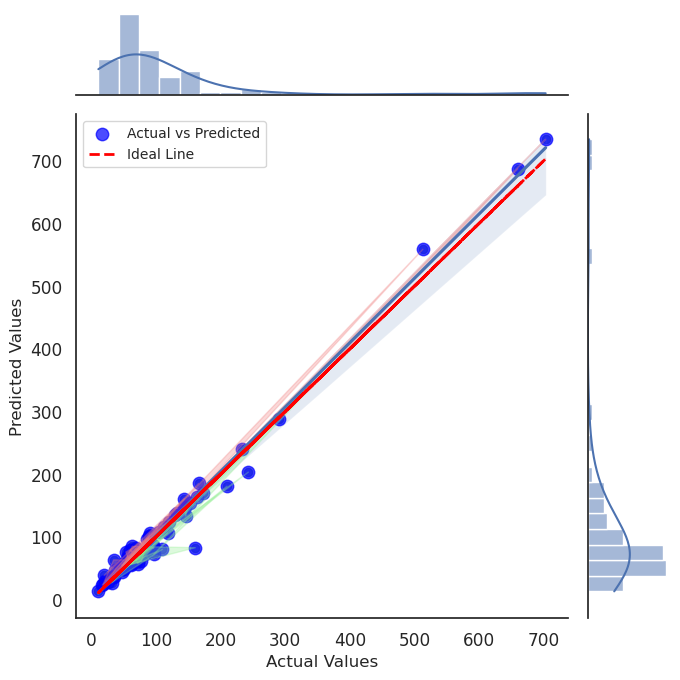

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your data and plots setup (assuming result1 is defined)

# First, create the jointplot with regression line
plt.figure(figsize=(8, 8))
sns.set(style="white", color_codes=True)
sns.set_context("notebook", font_scale=1.1)
sns.jointplot(x=result1['y_test'], y=result1['y_pred'], kind='reg', color='b', height=7)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)

# Extract axes to overlay additional plots
ax = plt.gca()

# Overlay scatter plot with improved aesthetics
ax.scatter(result1['y_test'], result1['y_pred'], color='blue', alpha=0.7, label='Actual vs Predicted', s=80)

# Plot the ideal line y_test = y_pred
ax.plot(result1['y_test'], result1['y_test'], color='red', linestyle='--', label='Ideal Line', linewidth=2)

# Add shaded regions to indicate residuals
ax.fill_between(result1['y_test'], result1['y_pred'], result1['y_test'], where=(result1['y_pred'] >= result1['y_test']), interpolate=True, color='lightcoral', alpha=0.3)
ax.fill_between(result1['y_test'], result1['y_pred'], result1['y_test'], where=(result1['y_pred'] < result1['y_test']), interpolate=True, color='lightgreen', alpha=0.3)

# Adjust plot aesthetics
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=10)

# Save or display the combined plot
plt.tight_layout()
plt.savefig('xgboost_combined_plot.pdf')
plt.show()

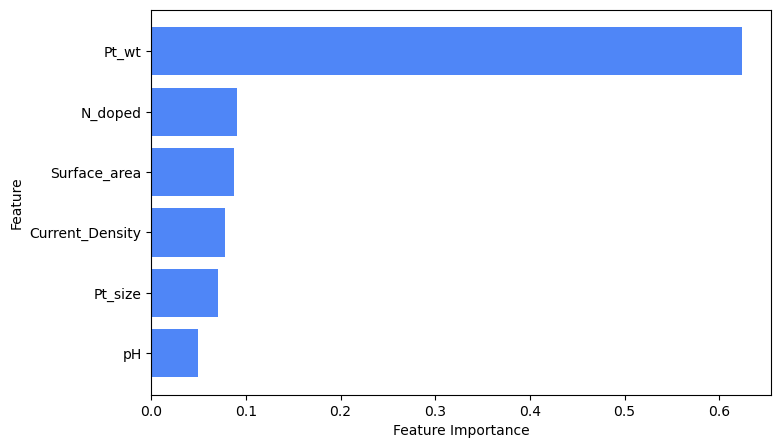

In [7]:
feature_importances = xgb_reg.feature_importances_  # Corrected to access the feature importances from the model
feature_names = features.columns

# Zip feature names and importances together and sort them by importance
sorted_features = sorted(zip(feature_importances, feature_names))

# Unzip the sorted feature names and importances
sorted_importances, sorted_names = zip(*sorted_features)

# Visualization of feature importances in ascending order
n_features = len(features.columns)
plt.figure(figsize=(8, 5))
plt.barh(range(n_features), sorted_importances, align='center', color='#4F86F7')
plt.yticks(range(n_features), sorted_names)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.savefig('feature_importances_gbx_sorted.jpg', bbox_inches='tight', transparent=True, dpi=900)
plt.show()

### SHAP

/tmp/ipykernel_35442/2334556203.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = plt.cm.get_cmap('RdBu').reversed()


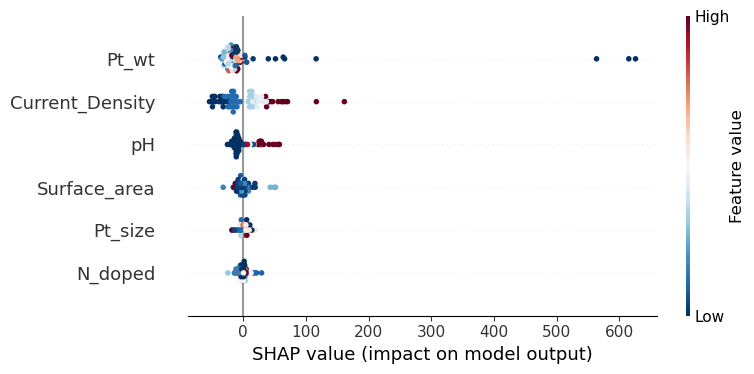

In [9]:
import shap

feature_names = ['Pt_wt', 'Pt_size', 'Surface_area', 'N_doped', 'pH', 'Current_Density']

explainer = shap.Explainer(xgb_reg, train_set_scaled)
y_base = explainer.expected_value
#print(y_base)
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 12
my_cmap = plt.cm.get_cmap('RdBu').reversed()
shap_values = explainer(test_set_scaled)
fig = plt.figure() #figsize=(8, 4)
shap.summary_plot(shap_values, test_set_scaled, feature_names=feature_names, show=False, cmap=my_cmap)
plt.savefig('SHAP_Value_Impact_summary_plot.tiff')
plt.show()

In [21]:
shap.initjs()
explainer = shap.TreeExplainer(xgb_reg)

y_base = explainer.expected_value
print(y_base)


[0.5]


In [22]:

predictt = xgb_reg.predict(X_train)
print(predictt.mean())


192.07393


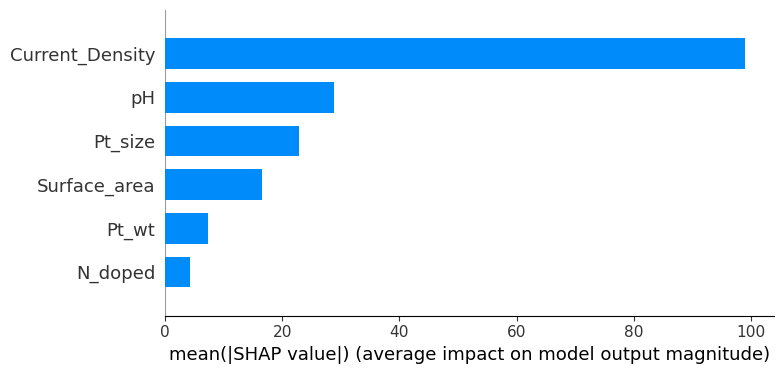

In [23]:

shap_values = explainer.shap_values(features)
fig2=shap.summary_plot(shap_values, features, plot_type="bar")
plt.show()

 96%|=================== | 292/303 [00:21<00:00]       

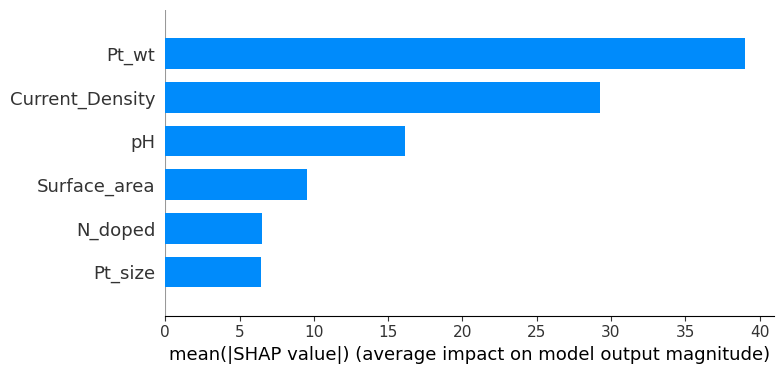

In [25]:
explainer = shap.Explainer(xgb_reg, train_set_scaled)
shap_values = explainer(train_set_scaled)

# SHAP values for the training data
shap_values_matrix = shap_values.values

# Summary plot
shap.summary_plot(shap_values_matrix, X_train, plot_type="bar")
plt.show()

### DALEX

In [8]:
import dalex as dx

In [9]:
exp_cat = dx.Explainer(xgb_reg, features, labels, 
                    label = "Overpotential (mV)")

Preparation of a new explainer is initiated

  -> data              : 379 rows 6 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 379 values
  -> model_class       : xgboost.sklearn.XGBRegressor (default)
  -> label             : Overpotential (mV)
  -> predict function  : <function yhat_default at 0x7f99c810cee0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.84e+02, mean = 1.92e+02, max = 2e+02
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.9e+02, mean = -86.2, max = 5.68e+02
  -> model_info        : package xgboost

A new explainer has been created!


In [10]:
cp_exp_cat  = exp_cat.predict_profile(X_test)
cp_exp_cat.result

Calculating ceteris paribus: 100%|██████████| 6/6 [00:00<00:00, 28.26it/s]


Pt_wt  Pt_size  Surface_area  N_doped   pH  Current_Density  _original_  \
288  0.000     0.35          28.0      0.0  0.3             50.0         0.5   
288  0.100     0.35          28.0      0.0  0.3             50.0         0.5   
288  0.130     0.35          28.0      0.0  0.3             50.0         0.5   
288  0.210     0.35          28.0      0.0  0.3             50.0         0.5   
288  0.314     0.35          28.0      0.0  0.3             50.0         0.5   
..     ...      ...           ...      ...  ...              ...         ...   
332  0.340     1.00          89.4      0.0  0.3            192.4        40.0   
332  0.340     1.00          89.4      0.0  0.3            194.3        40.0   
332  0.340     1.00          89.4      0.0  0.3            196.2        40.0   
332  0.340     1.00          89.4      0.0  0.3            198.1        40.0   
332  0.340     1.00          89.4      0.0  0.3            200.0        40.0   

         _yhat_          _vname_  _ids_             _label_  
288  193.806885            Pt_wt    288  Overpotential (mV)  
288  191.452026            Pt_wt    288  Overpotential (mV)  
288  191.558716            Pt_wt    288  Overpotential (mV)  
288  205.686890            Pt_wt    288  Overpotential (mV)  
288  198.134766            Pt_wt    288  Overpotential (mV)  
..          ...              ...    ...                 ...  
332  192.312256  Current_Density    332  Overpotential (mV)  
332  192.312256  Current_Density    332  Overpotential (mV)  
332  192.312256  Current_Density    332  Overpotential (mV)  
332  192.312256  Current_Density    332  Overpotential (mV)  
332  192.312256  Current_Density    332  Overpotential (mV)  

[54568 rows x 11 columns]

In [11]:
import plotly.io as pio
fig_cp_exp_cat_Particle_size = cp_exp_cat.plot(variables=["Pt_wt"], show=False)

pio.write_image(fig_cp_exp_cat_Particle_size, "xgb_Pt_wt_plot.pdf")

In [12]:
asp = dx.Aspect(exp_cat)

In [13]:
asp_pps = dx.Aspect(exp_cat, depend_method = 'pps')

In [14]:
asp_pps.plot_dendrogram(title='XGBoost Hierarchical clustering dendrogram (with PPS)')

In [15]:
mt = asp.model_triplot(random_state=42)
mt

In [16]:
mt.plot(title='XGBoost Triplot')

### K-Fold

In [9]:
from sklearn.metrics import make_scorer, r2_score
K_fold_scaled = scaler.fit_transform(features)
strKFold = KFold(n_splits=3,shuffle=True,random_state=0)
r2_scorer = make_scorer(r2_score)
scores = cross_val_score(xgb_reg, K_fold_scaled, labels, cv=strKFold, scoring=r2_scorer)
print("R-squared scores from cross-validation:", scores)
print("Mean R-squared score:", scores.mean())
print("Standard deviation of R-squared scores:", scores.std())

R-squared scores from cross-validation: [0.96140626 0.95745469 0.82504064]
Mean R-squared score: 0.914633861490359
Standard deviation of R-squared scores: 0.06337251085326462


In [12]:
from sklearn.metrics import make_scorer, r2_score
strKFold = KFold(n_splits=4,shuffle=True,random_state=0)
r2_scorer = make_scorer(r2_score)
scores = cross_val_score(xgb_reg, K_fold_scaled, labels, cv=strKFold, scoring=r2_scorer)
print("R-squared scores from cross-validation:", scores)
print("Mean R-squared score:", scores.mean())
print("Standard deviation of R-squared scores:", scores.std())

R-squared scores from cross-validation: [0.97596109 0.96477772 0.96697289 0.88793735]
Mean R-squared score: 0.9489122646797741
Standard deviation of R-squared scores: 0.03545235720509478


In [13]:
from sklearn.metrics import make_scorer, r2_score
strKFold = KFold(n_splits=5,shuffle=True,random_state=0)
r2_scorer = make_scorer(r2_score)
scores = cross_val_score(xgb_reg, K_fold_scaled, labels, cv=strKFold, scoring=r2_scorer)
print("R-squared scores from cross-validation:", scores)
print("Mean R-squared score:", scores.mean())
print("Standard deviation of R-squared scores:", scores.std())

R-squared scores from cross-validation: [0.97764206 0.98105871 0.96574426 0.93764305 0.97664929]
Mean R-squared score: 0.9677474744491616
Standard deviation of R-squared scores: 0.015903607427775


In [14]:
strKFold = KFold(n_splits=10,shuffle=True,random_state=0)
scores = cross_val_score(xgb_reg, K_fold_scaled, labels, cv=strKFold)
mean_score = scores.mean()
std_dev_score = scores.std()

# Print the results
print("KFold cross-validation scores:{}".format(scores))
print("Mean score of KFold cross-validation: {:.3f}".format(mean_score))
print("Standard deviation of KFold cross-validation: {:.3f}".format(std_dev_score))

KFold cross-validation scores:[0.99255116 0.96577468 0.99140602 0.97423267 0.96074033 0.98836663
 0.91966057 0.95971845 0.98383528 0.95574303]
Mean score of KFold cross-validation: 0.969
Standard deviation of KFold cross-validation: 0.021


In [12]:
baseline_mae = 13.74
baseline_mse = 338
baseline_r2 = 0.97

# Proposed Model results
proposed_r2_test = 0.9811
proposed_mae_test = 10.84
proposed_mse_test = 267.7

# Calculate improvements
improvement_r2 = (proposed_r2_test - baseline_r2) / baseline_r2 * 100
improvement_mae = (baseline_mae - proposed_mae_test) / baseline_mae * 100
improvement_mse = (baseline_mse - proposed_mse_test) / baseline_mse * 100

# Print baseline and proposed model results with improvements
print("Baseline Model Results:")
print("Baseline R2: %.4g" % baseline_r2)
print("Baseline MAE: %.4g" % baseline_mae)
print("Baseline MSE: %.4g" % baseline_mse)


print("\nProposed Model Results:")
print("Proposed Model r2: %.4g" % proposed_r2_test)
print("Proposed Model MAE: %.4g" % proposed_mae_test)
print("Proposed Model mse: %.4g" % proposed_mse_test)

print("\nImprovements:")
print("Improvement in R2: %.2f%%" % improvement_r2)
print("Improvement in MAE: %.2f%%" % improvement_mae)
print("Improvement in MSE: %.2f%%" % improvement_mse)

Baseline Model Results:
Baseline R2: 0.97
Baseline MAE: 13.74
Baseline MSE: 338

Proposed Model Results:
Proposed Model r2: 0.9811
Proposed Model MAE: 10.84
Proposed Model mse: 267.7

Improvements:
Improvement in R2: 1.14%
Improvement in MAE: 21.11%
Improvement in MSE: 20.80%


In [86]:
data_input=pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/mmc3.csv", sep=',')
labels=data_input['Overpotential']
features=data_input.drop('Overpotential', axis=1).drop('DOI', axis=1)

X_train,X_test,y_train,y_test=train_test_split(features, labels, test_size=0.001, random_state=42) #42
scaler = MinMaxScaler(feature_range=(-1, 1))
train_set_scaled = scaler.fit_transform(X_train)
X_train

Pt_wt  Pt_size  Surface_area  N_doped    pH  Current_Density
283   0.50     0.35        282.00    12.08   0.3               40
327   0.35     1.00         92.85     0.00   0.5              100
145   5.80     4.30         27.20     0.00   0.3               40
55   11.24    10.00         96.50     3.40  14.0               40
93    9.50     5.00        109.75     4.50   7.4               10
..     ...      ...           ...      ...   ...              ...
71   10.00     3.50        254.00     0.00   0.3               20
106   7.49     5.00        128.40     3.50  14.0               40
270   1.00     0.54        282.00    12.08   0.3               10
348   0.25     0.35        282.00    12.08   0.3               20
102   7.49     5.00        128.40     3.50   0.3              150

[378 rows x 6 columns]

In [88]:
base_xgb_reg = XGBRegressor(
    n_estimators=1500,         
    learning_rate=0.05,       
    max_depth=7,              
    subsample=0.5,             
    colsample_bytree=1.0,      
    reg_lambda=1,             
    reg_alpha=1,               
    objective='reg:squarederror', 
    random_state=0,        )    

# Fit the model
base_xgb_reg.fit(train_set_scaled, y_train, eval_metric='rmse', verbose=True, eval_set=[(train_set_scaled, y_train)], early_stopping_rounds=100)

[0]	validation_0-rmse:156.12381
[1]	validation_0-rmse:150.44918


/home/kumail/anaconda3/envs/rapids-23.04/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/kumail/anaconda3/envs/rapids-23.04/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-rmse:144.20140
[3]	validation_0-rmse:138.37302
[4]	validation_0-rmse:132.89944
[5]	validation_0-rmse:128.11487
[6]	validation_0-rmse:123.10011
[7]	validation_0-rmse:118.24507
[8]	validation_0-rmse:113.45169
[9]	validation_0-rmse:108.99821
[10]	validation_0-rmse:105.00500
[11]	validation_0-rmse:100.88747
[12]	validation_0-rmse:96.96051
[13]	validation_0-rmse:93.32939
[14]	validation_0-rmse:89.76602
[15]	validation_0-rmse:86.90461
[16]	validation_0-rmse:83.73674
[17]	validation_0-rmse:80.65780
[18]	validation_0-rmse:77.90340
[19]	validation_0-rmse:75.36533
[20]	validation_0-rmse:72.87763
[21]	validation_0-rmse:70.51649
[22]	validation_0-rmse:67.98756
[23]	validation_0-rmse:65.61251
[24]	validation_0-rmse:63.43587
[25]	validation_0-rmse:61.27396
[26]	validation_0-rmse:59.26394
[27]	validation_0-rmse:57.39733
[28]	validation_0-rmse:55.30261
[29]	validation_0-rmse:53.76085
[30]	validation_0-rmse:51.96757
[31]	validation_0-rmse:50.19879
[32]	validation_0-rmse:48.78272
[33]	v

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [73]:
Commercial_Pt_C_03_Test_Data =pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/Commercial_Pt_C_0.3.csv", sep=',')
PtNMC1_03_Test_Data =pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/1PtNMC_0.3.csv", sep=',')
PtNMC2_03_Test_Data =pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/2PtNMC_0.3.csv", sep=',')
PtNMC3_03_Test_Data =pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/3PtMNC_0.3.csv", sep=',')
PtNMC5_03_Test_Data =pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/5PtMNC_0.3.csv", sep=',')
Commercial_Pt_C_14_Test_Data =pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/Commercial_Pt_C_14.csv", sep=',')
PtNMC1_14_Test_Data =pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/1PtNMC_14.csv", sep=',')
PtNMC2_14_Test_Data =pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/2PtNMC_14.csv", sep=',')
PtNMC3_14_Test_Data =pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/3PtMNC_14.csv", sep=',')
PtNMC5_14_Test_Data =pd.read_csv("/home/kumail/Energy_AI/ML-Metal-HER-Catalyst/Proposed Model/Dataset2/5PtMNC_14.csv", sep=',')

def split_dataframe(df):
    df = df.drop(columns=['Samples'])
    X = df[['Pt_wt', 'Pt_size', 'Surface_area', 'N_doped', 'pH', 'Current_Density']]
    Y = df['Overpotential']
    return X, Y

X_Commercial_Pt_C_03_Test_Data_Test_Data, Y_Commercial_Pt_C_03_Test_Data_Test_Data = split_dataframe(Commercial_Pt_C_03_Test_Data)
X_PtNMC1_03_Test_Data, Y_PtNMC1_03_Test_Data = split_dataframe(PtNMC1_03_Test_Data)
X_PtNMC2_03_Test_Data, Y_PtNMC2_03_Test_Data = split_dataframe(PtNMC2_03_Test_Data)
X_PtNMC3_03_Test_Data, Y_PtNMC3_03_Test_Data = split_dataframe(PtNMC3_03_Test_Data)
X_PtNMC5_03_Test_Data, Y_PtNMC5_03_Test_Data = split_dataframe(PtNMC5_03_Test_Data)
X_Commercial_Pt_C_14_Test_Data, Y_Commercial_Pt_C_14_Test_Data = split_dataframe(Commercial_Pt_C_14_Test_Data)
X_PtNMC1_14_Test_Data, Y_PtNMC1_14_Test_Data = split_dataframe(PtNMC1_14_Test_Data)
X_PtNMC2_14_Test_Data, Y_PtNMC2_14_Test_Data = split_dataframe(PtNMC2_14_Test_Data)
X_PtNMC3_14_Test_Data, Y_PtNMC3_14_Test_Data = split_dataframe(PtNMC3_14_Test_Data)
X_PtNMC5_14_Test_Data, Y_PtNMC5_14_Test_Data = split_dataframe(PtNMC5_14_Test_Data)

In [74]:
X_Commercial_Pt_C_03_Test_Data_Test_Data

Pt_wt  Pt_size  Surface_area  N_doped   pH  Current_Density
0   11.6        1         488.9      8.2  0.3               10
1   11.6        1         488.9      8.2  0.3               20
2   11.6        1         488.9      8.2  0.3               40
3   11.6        1         488.9      8.2  0.3               50
4   11.6        1         488.9      8.2  0.3              100

In [89]:
test_set_scaled = scaler.transform(X_Commercial_Pt_C_03_Test_Data_Test_Data)
y_pred = base_xgb_reg.predict(test_set_scaled)
result1 = pd.DataFrame(columns=['y_test', 'y_pred'])
result1['y_test'] = Y_Commercial_Pt_C_03_Test_Data_Test_Data 
result1['y_pred'] = y_pred

result1

y_test     y_pred
0    36.3  36.199581
1    45.0  45.154865
2    57.7  53.288376
3    66.3  66.266602
4   103.0  99.473221

In [90]:
test_set_scaled = scaler.transform(X_PtNMC1_03_Test_Data)

# Make predictions using the trained XGBoost model
y_pred = base_xgb_reg.predict(test_set_scaled)

# Create a DataFrame to compare the actual and predicted values
result1 = pd.DataFrame(columns=['y_test', 'y_pred'])
result1['y_test'] = Y_PtNMC1_03_Test_Data
result1['y_pred'] = y_pred

# Display the results
result1

y_test     y_pred
0    43.0  22.380346
1    57.0  37.614674
2    82.3  57.315609
3    94.3  66.752342
4   155.7  84.591476

In [91]:
test_set_scaled = scaler.transform(X_PtNMC2_03_Test_Data)
y_pred = base_xgb_reg.predict(test_set_scaled)

result1 = pd.DataFrame(columns=['y_test', 'y_pred'])
result1['y_test'] = Y_PtNMC2_03_Test_Data
result1['y_pred'] = y_pred
result1

y_test     y_pred
0    38.0  19.426105
1    52.3  23.828724
2    76.3  37.163887
3    91.0  51.844856
4   151.0  83.864037

In [92]:
test_set_scaled = scaler.transform(X_PtNMC3_03_Test_Data)
y_pred = base_xgb_reg.predict(test_set_scaled)
result1 = pd.DataFrame(columns=['y_test', 'y_pred'])
result1['y_test'] = Y_PtNMC3_03_Test_Data
result1['y_pred'] = y_pred
result1

y_test      y_pred
0    35.7   33.178669
1    48.3   48.730118
2    69.0   59.465450
3    79.7   72.745102
4   131.0  106.864563

In [93]:
test_set_scaled = scaler.transform(X_PtNMC5_03_Test_Data)
y_pred = base_xgb_reg.predict(test_set_scaled)
result1 = pd.DataFrame(columns=['y_test', 'y_pred'])
result1['y_test'] = Y_PtNMC5_03_Test_Data
result1['y_pred'] = y_pred
result1

y_test      y_pred
0    39.0   35.384544
1    51.7   42.652733
2    73.7   62.333519
3    85.0   81.500641
4   139.0  107.805550

In [94]:
test_set_scaled = scaler.transform(X_Commercial_Pt_C_14_Test_Data)
y_pred = base_xgb_reg.predict(test_set_scaled)
result1 = pd.DataFrame(columns=['y_test', 'y_pred'])
result1['y_test'] = Y_Commercial_Pt_C_14_Test_Data
result1['y_pred'] = y_pred
result1

y_test      y_pred
0    28.9   51.428982
1    53.6  105.117767
2    97.6  153.658020
3   118.3  171.486572
4   217.6  222.345657

In [95]:
test_set_scaled = scaler.transform(X_PtNMC1_14_Test_Data)
y_pred = base_xgb_reg.predict(test_set_scaled)
result1 = pd.DataFrame(columns=['y_test', 'y_pred'])
result1['y_test'] = Y_PtNMC1_14_Test_Data
result1['y_pred'] = y_pred
result1

y_test      y_pred
0    58.3   36.642727
1    98.9   79.145142
2   160.3  129.920975
3   188.9  143.755829
4   312.3  196.027130

In [96]:
test_set_scaled = scaler.transform(X_PtNMC2_14_Test_Data)
y_pred = base_xgb_reg.predict(test_set_scaled)
result1 = pd.DataFrame(columns=['y_test', 'y_pred'])
result1['y_test'] = Y_PtNMC2_14_Test_Data
result1['y_pred'] = y_pred
result1

y_test      y_pred
0    21.6   30.939812
1    46.9   62.212376
2    84.6  111.060822
3   112.9  133.178741
4   211.6  194.235458

In [97]:
test_set_scaled = scaler.transform(X_PtNMC3_14_Test_Data)
y_pred = base_xgb_reg.predict(test_set_scaled)
result1 = pd.DataFrame(columns=['y_test', 'y_pred'])
result1['y_test'] = Y_PtNMC3_14_Test_Data
result1['y_pred'] = y_pred
result1

y_test      y_pred
0    21.6   46.665482
1    46.3   97.931671
2    87.6  157.532578
3   106.9  178.936783
4   190.3  237.770462

In [98]:
test_set_scaled = scaler.transform(X_PtNMC5_14_Test_Data)
y_pred = base_xgb_reg.predict(test_set_scaled)
result1 = pd.DataFrame(columns=['y_test', 'y_pred'])
result1['y_test'] = Y_PtNMC5_14_Test_Data
result1['y_pred'] = y_pred
result1

y_test      y_pred
0    23.6   39.043236
1    44.3   72.825027
2    83.6  129.483124
3   102.3  150.840485
4   183.6  199.421356

### For 0.3 Commercial Pt/C

In [6]:
# Define the experimental values, baseline model predicted values, and proposed model predicted values
experimental_values = [36.3, 45, 57.7, 66.3, 103]
baseline_predicted_values = [42.2, 56.5, 67.2, 75.7, 100.8]
proposed_predicted_values = [36.19, 45.15, 53.28, 66.26, 99.47]  # Example values, replace with actual proposed model predictions

# Function to calculate relative error
def calculate_relative_error(exp, pred):
    return abs(pred - exp) / exp * 100

# Calculate relative errors for both models
baseline_relative_errors = [calculate_relative_error(exp, pred) for exp, pred in zip(experimental_values, baseline_predicted_values)]
proposed_relative_errors = [calculate_relative_error(exp, pred) for exp, pred in zip(experimental_values, proposed_predicted_values)]

# Calculate improvement of proposed model with respect to baseline model
improvement = [(baseline - proposed) for baseline, proposed in zip(baseline_relative_errors, proposed_relative_errors)]

# Print the results
print("Baseline Model Relative Errors (%):")
for exp, pred, error in zip(experimental_values, baseline_predicted_values, baseline_relative_errors):
    print(f"ηExp(mV): {exp}, ηBaselinePred(mV): {pred}, Relative error(%): {error:.1f}")

print("\nProposed Model Relative Errors (%):")
for exp, pred, error in zip(experimental_values, proposed_predicted_values, proposed_relative_errors):
    print(f"ηExp(mV): {exp}, ηProposedPred(mV): {pred}, Relative error(%): {error:.1f}")

print("\nImprovement of Proposed Model w.r.t Baseline Model (%):")
improvements = []

for baseline, proposed in zip(baseline_predicted_values, proposed_predicted_values):
    improvement = ((baseline - proposed) / baseline) * 100
    improvements.append(improvement)
    
for i, improvement in enumerate(improvements, 1):
    print(f"Pair {i}: {improvement:.2f}")


Baseline Model Relative Errors (%):
ηExp(mV): 36.3, ηBaselinePred(mV): 42.2, Relative error(%): 16.3
ηExp(mV): 45, ηBaselinePred(mV): 56.5, Relative error(%): 25.6
ηExp(mV): 57.7, ηBaselinePred(mV): 67.2, Relative error(%): 16.5
ηExp(mV): 66.3, ηBaselinePred(mV): 75.7, Relative error(%): 14.2
ηExp(mV): 103, ηBaselinePred(mV): 100.8, Relative error(%): 2.1

Proposed Model Relative Errors (%):
ηExp(mV): 36.3, ηProposedPred(mV): 36.19, Relative error(%): 0.3
ηExp(mV): 45, ηProposedPred(mV): 45.15, Relative error(%): 0.3
ηExp(mV): 57.7, ηProposedPred(mV): 53.28, Relative error(%): 7.7
ηExp(mV): 66.3, ηProposedPred(mV): 66.26, Relative error(%): 0.1
ηExp(mV): 103, ηProposedPred(mV): 99.47, Relative error(%): 3.4

Improvement of Proposed Model w.r.t Baseline Model (%):
Pair 1: 14.24
Pair 2: 20.09
Pair 3: 20.71
Pair 4: 12.47
Pair 5: 1.32


### For 14 Commercial Pt/C

In [7]:
experimental_values = [28.9, 53.6, 97.6, 118.3, 217.6]
baseline_predicted_values = [54.9, 98.4, 132.8, 136.7, 186.8]
proposed_predicted_values = [51.42, 105.11, 153.65, 171.48, 222.34]  # Example values, replace with actual proposed model predictions

# Function to calculate relative error
def calculate_relative_error(exp, pred):
    return abs(pred - exp) / exp * 100

# Calculate relative errors for both models
baseline_relative_errors = [calculate_relative_error(exp, pred) for exp, pred in zip(experimental_values, baseline_predicted_values)]
proposed_relative_errors = [calculate_relative_error(exp, pred) for exp, pred in zip(experimental_values, proposed_predicted_values)]

# Calculate improvement of proposed model with respect to baseline model
improvement = [(baseline - proposed) for baseline, proposed in zip(baseline_relative_errors, proposed_relative_errors)]

# Print the results
print("Baseline Model Relative Errors (%):")
for exp, pred, error in zip(experimental_values, baseline_predicted_values, baseline_relative_errors):
    print(f"ηExp(mV): {exp}, ηBaselinePred(mV): {pred}, Relative error(%): {error:.1f}")

print("\nProposed Model Relative Errors (%):")
for exp, pred, error in zip(experimental_values, proposed_predicted_values, proposed_relative_errors):
    print(f"ηExp(mV): {exp}, ηProposedPred(mV): {pred}, Relative error(%): {error:.1f}")

print("\nImprovement of Proposed Model w.r.t Baseline Model (%):")
improvements = []

for baseline, proposed in zip(baseline_predicted_values, proposed_predicted_values):
    improvement = ((baseline - proposed) / baseline) * 100
    improvements.append(improvement)
    
for i, improvement in enumerate(improvements, 1):
    print(f"Pair {i}: {improvement:.2f}")

Baseline Model Relative Errors (%):
ηExp(mV): 28.9, ηBaselinePred(mV): 54.9, Relative error(%): 90.0
ηExp(mV): 53.6, ηBaselinePred(mV): 98.4, Relative error(%): 83.6
ηExp(mV): 97.6, ηBaselinePred(mV): 132.8, Relative error(%): 36.1
ηExp(mV): 118.3, ηBaselinePred(mV): 136.7, Relative error(%): 15.6
ηExp(mV): 217.6, ηBaselinePred(mV): 186.8, Relative error(%): 14.2

Proposed Model Relative Errors (%):
ηExp(mV): 28.9, ηProposedPred(mV): 51.42, Relative error(%): 77.9
ηExp(mV): 53.6, ηProposedPred(mV): 105.11, Relative error(%): 96.1
ηExp(mV): 97.6, ηProposedPred(mV): 153.65, Relative error(%): 57.4
ηExp(mV): 118.3, ηProposedPred(mV): 171.48, Relative error(%): 45.0
ηExp(mV): 217.6, ηProposedPred(mV): 222.34, Relative error(%): 2.2

Improvement of Proposed Model w.r.t Baseline Model (%):
Pair 1: 6.34
Pair 2: -6.82
Pair 3: -15.70
Pair 4: -25.44
Pair 5: -19.03


### For 14 1Pt@NMC

In [8]:
experimental_values = [58.3,98.9 ,160.3 ,188.9 ,312.3 ]
baseline_predicted_values = [47.6, 89.4,117.7 , 134.9,180.9 ]
proposed_predicted_values = [36.64,79.14 ,129.92 ,143.75 ,196.02 ]  # Example values, replace with actual proposed model predictions

def calculate_relative_error(exp, pred):
    return abs(pred - exp) / exp * 100

# Calculate relative errors for both models
baseline_relative_errors = [calculate_relative_error(exp, pred) for exp, pred in zip(experimental_values, baseline_predicted_values)]
proposed_relative_errors = [calculate_relative_error(exp, pred) for exp, pred in zip(experimental_values, proposed_predicted_values)]

# Calculate improvement of proposed model with respect to baseline model
improvement = [(baseline - proposed) for baseline, proposed in zip(baseline_relative_errors, proposed_relative_errors)]

# Print the results
print("Baseline Model Relative Errors (%):")
for exp, pred, error in zip(experimental_values, baseline_predicted_values, baseline_relative_errors):
    print(f"ηExp(mV): {exp}, ηBaselinePred(mV): {pred}, Relative error(%): {error:.1f}")

print("\nProposed Model Relative Errors (%):")
for exp, pred, error in zip(experimental_values, proposed_predicted_values, proposed_relative_errors):
    print(f"ηExp(mV): {exp}, ηProposedPred(mV): {pred}, Relative error(%): {error:.1f}")

print("\nImprovement of Proposed Model w.r.t Baseline Model (%):")
improvements = []

for baseline, proposed in zip(baseline_predicted_values, proposed_predicted_values):
    improvement = ((baseline - proposed) / baseline) * 100
    improvements.append(improvement)
    
for i, improvement in enumerate(improvements, 1):
    print(f"Pair {i}: {improvement:.2f}")

Baseline Model Relative Errors (%):
ηExp(mV): 58.3, ηBaselinePred(mV): 47.6, Relative error(%): 18.4
ηExp(mV): 98.9, ηBaselinePred(mV): 89.4, Relative error(%): 9.6
ηExp(mV): 160.3, ηBaselinePred(mV): 117.7, Relative error(%): 26.6
ηExp(mV): 188.9, ηBaselinePred(mV): 134.9, Relative error(%): 28.6
ηExp(mV): 312.3, ηBaselinePred(mV): 180.9, Relative error(%): 42.1

Proposed Model Relative Errors (%):
ηExp(mV): 58.3, ηProposedPred(mV): 36.64, Relative error(%): 37.2
ηExp(mV): 98.9, ηProposedPred(mV): 79.14, Relative error(%): 20.0
ηExp(mV): 160.3, ηProposedPred(mV): 129.92, Relative error(%): 19.0
ηExp(mV): 188.9, ηProposedPred(mV): 143.75, Relative error(%): 23.9
ηExp(mV): 312.3, ηProposedPred(mV): 196.02, Relative error(%): 37.2

Improvement of Proposed Model w.r.t Baseline Model (%):
Pair 1: 23.03
Pair 2: 11.48
Pair 3: -10.38
Pair 4: -6.56
Pair 5: -8.36


### For 0.3 1Pt@NMC

In [9]:
experimental_values = [43,57 ,82.3 ,94.3 ,155.7 ]
baseline_predicted_values = [41.3,58.4 ,64.3 ,66.6 , 78.6]
proposed_predicted_values = [22.38,37.61 ,57.31 , 66.75,84.59 ]  # Example values, replace with actual proposed model predictions

def calculate_relative_error(exp, pred):
    return abs(pred - exp) / exp * 100

# Calculate relative errors for both models
baseline_relative_errors = [calculate_relative_error(exp, pred) for exp, pred in zip(experimental_values, baseline_predicted_values)]
proposed_relative_errors = [calculate_relative_error(exp, pred) for exp, pred in zip(experimental_values, proposed_predicted_values)]

# Calculate improvement of proposed model with respect to baseline model
improvement = [(baseline - proposed) for baseline, proposed in zip(baseline_relative_errors, proposed_relative_errors)]

# Print the results
print("Baseline Model Relative Errors (%):")
for exp, pred, error in zip(experimental_values, baseline_predicted_values, baseline_relative_errors):
    print(f"ηExp(mV): {exp}, ηBaselinePred(mV): {pred}, Relative error(%): {error:.1f}")

print("\nProposed Model Relative Errors (%):")
for exp, pred, error in zip(experimental_values, proposed_predicted_values, proposed_relative_errors):
    print(f"ηExp(mV): {exp}, ηProposedPred(mV): {pred}, Relative error(%): {error:.1f}")

print("\nImprovement of Proposed Model w.r.t Baseline Model (%):")
improvements = []

for baseline, proposed in zip(baseline_predicted_values, proposed_predicted_values):
    improvement = ((baseline - proposed) / baseline) * 100
    improvements.append(improvement)
    
for i, improvement in enumerate(improvements, 1):
    print(f"Pair {i}: {improvement:.2f}")

Baseline Model Relative Errors (%):
ηExp(mV): 43, ηBaselinePred(mV): 41.3, Relative error(%): 4.0
ηExp(mV): 57, ηBaselinePred(mV): 58.4, Relative error(%): 2.5
ηExp(mV): 82.3, ηBaselinePred(mV): 64.3, Relative error(%): 21.9
ηExp(mV): 94.3, ηBaselinePred(mV): 66.6, Relative error(%): 29.4
ηExp(mV): 155.7, ηBaselinePred(mV): 78.6, Relative error(%): 49.5

Proposed Model Relative Errors (%):
ηExp(mV): 43, ηProposedPred(mV): 22.38, Relative error(%): 48.0
ηExp(mV): 57, ηProposedPred(mV): 37.61, Relative error(%): 34.0
ηExp(mV): 82.3, ηProposedPred(mV): 57.31, Relative error(%): 30.4
ηExp(mV): 94.3, ηProposedPred(mV): 66.75, Relative error(%): 29.2
ηExp(mV): 155.7, ηProposedPred(mV): 84.59, Relative error(%): 45.7

Improvement of Proposed Model w.r.t Baseline Model (%):
Pair 1: 45.81
Pair 2: 35.60
Pair 3: 10.87
Pair 4: -0.23
Pair 5: -7.62


### For 14 2Pt@NMC

In [10]:
experimental_values = [21.6,46.9 ,84.9 ,112.9 , 211.6]
baseline_predicted_values = [47.6,87.6 ,109.7 ,129.5 ,179.1 ]
proposed_predicted_values = [30.93,62.21 ,111.06 ,133.17 ,194.23 ]  # Example values, replace with actual proposed model predictions

def calculate_relative_error(exp, pred):
    return abs(pred - exp) / exp * 100

# Calculate relative errors for both models
baseline_relative_errors = [calculate_relative_error(exp, pred) for exp, pred in zip(experimental_values, baseline_predicted_values)]
proposed_relative_errors = [calculate_relative_error(exp, pred) for exp, pred in zip(experimental_values, proposed_predicted_values)]

# Calculate improvement of proposed model with respect to baseline model
improvement = [(baseline - proposed) for baseline, proposed in zip(baseline_relative_errors, proposed_relative_errors)]

# Print the results
print("Baseline Model Relative Errors (%):")
for exp, pred, error in zip(experimental_values, baseline_predicted_values, baseline_relative_errors):
    print(f"ηExp(mV): {exp}, ηBaselinePred(mV): {pred}, Relative error(%): {error:.1f}")

print("\nProposed Model Relative Errors (%):")
for exp, pred, error in zip(experimental_values, proposed_predicted_values, proposed_relative_errors):
    print(f"ηExp(mV): {exp}, ηProposedPred(mV): {pred}, Relative error(%): {error:.1f}")

print("\nImprovement of Proposed Model w.r.t Baseline Model (%):")
improvements = []

for baseline, proposed in zip(baseline_predicted_values, proposed_predicted_values):
    improvement = ((baseline - proposed) / baseline) * 100
    improvements.append(improvement)
    
for i, improvement in enumerate(improvements, 1):
    print(f"Pair {i}: {improvement:.2f}")

Baseline Model Relative Errors (%):
ηExp(mV): 21.6, ηBaselinePred(mV): 47.6, Relative error(%): 120.4
ηExp(mV): 46.9, ηBaselinePred(mV): 87.6, Relative error(%): 86.8
ηExp(mV): 84.9, ηBaselinePred(mV): 109.7, Relative error(%): 29.2
ηExp(mV): 112.9, ηBaselinePred(mV): 129.5, Relative error(%): 14.7
ηExp(mV): 211.6, ηBaselinePred(mV): 179.1, Relative error(%): 15.4

Proposed Model Relative Errors (%):
ηExp(mV): 21.6, ηProposedPred(mV): 30.93, Relative error(%): 43.2
ηExp(mV): 46.9, ηProposedPred(mV): 62.21, Relative error(%): 32.6
ηExp(mV): 84.9, ηProposedPred(mV): 111.06, Relative error(%): 30.8
ηExp(mV): 112.9, ηProposedPred(mV): 133.17, Relative error(%): 18.0
ηExp(mV): 211.6, ηProposedPred(mV): 194.23, Relative error(%): 8.2

Improvement of Proposed Model w.r.t Baseline Model (%):
Pair 1: 35.02
Pair 2: 28.98
Pair 3: -1.24
Pair 4: -2.83
Pair 5: -8.45


### For 0.3 2Pt@NMC

In [11]:
experimental_values = [38.0,52.3 ,76.3 ,91.0 , 151.0]
baseline_predicted_values = [29.8,44.2 ,68.0 ,71.2 ,89.0 ]
proposed_predicted_values = [19.42, 23.82, 37.16,51.84 ,83.86 ]  # Example values, replace with actual proposed model predictions

def calculate_relative_error(exp, pred):
    return abs(pred - exp) / exp * 100

# Calculate relative errors for both models
baseline_relative_errors = [calculate_relative_error(exp, pred) for exp, pred in zip(experimental_values, baseline_predicted_values)]
proposed_relative_errors = [calculate_relative_error(exp, pred) for exp, pred in zip(experimental_values, proposed_predicted_values)]

# Calculate improvement of proposed model with respect to baseline model
improvement = [(baseline - proposed) for baseline, proposed in zip(baseline_relative_errors, proposed_relative_errors)]

# Print the results
print("Baseline Model Relative Errors (%):")
for exp, pred, error in zip(experimental_values, baseline_predicted_values, baseline_relative_errors):
    print(f"ηExp(mV): {exp}, ηBaselinePred(mV): {pred}, Relative error(%): {error:.1f}")

print("\nProposed Model Relative Errors (%):")
for exp, pred, error in zip(experimental_values, proposed_predicted_values, proposed_relative_errors):
    print(f"ηExp(mV): {exp}, ηProposedPred(mV): {pred}, Relative error(%): {error:.1f}")

print("\nImprovement of Proposed Model w.r.t Baseline Model (%):")
improvements = []

for baseline, proposed in zip(baseline_predicted_values, proposed_predicted_values):
    improvement = ((baseline - proposed) / baseline) * 100
    improvements.append(improvement)
    
for i, improvement in enumerate(improvements, 1):
    print(f"Pair {i}: {improvement:.2f}")

Baseline Model Relative Errors (%):
ηExp(mV): 38.0, ηBaselinePred(mV): 29.8, Relative error(%): 21.6
ηExp(mV): 52.3, ηBaselinePred(mV): 44.2, Relative error(%): 15.5
ηExp(mV): 76.3, ηBaselinePred(mV): 68.0, Relative error(%): 10.9
ηExp(mV): 91.0, ηBaselinePred(mV): 71.2, Relative error(%): 21.8
ηExp(mV): 151.0, ηBaselinePred(mV): 89.0, Relative error(%): 41.1

Proposed Model Relative Errors (%):
ηExp(mV): 38.0, ηProposedPred(mV): 19.42, Relative error(%): 48.9
ηExp(mV): 52.3, ηProposedPred(mV): 23.82, Relative error(%): 54.5
ηExp(mV): 76.3, ηProposedPred(mV): 37.16, Relative error(%): 51.3
ηExp(mV): 91.0, ηProposedPred(mV): 51.84, Relative error(%): 43.0
ηExp(mV): 151.0, ηProposedPred(mV): 83.86, Relative error(%): 44.5

Improvement of Proposed Model w.r.t Baseline Model (%):
Pair 1: 34.83
Pair 2: 46.11
Pair 3: 45.35
Pair 4: 27.19
Pair 5: 5.78


### For 14 3Pt@NMC

In [12]:
experimental_values = [21.6,46.3 ,87.6 ,106.9 ,190.3 ]
baseline_predicted_values = [44.0, 93.7, 140.2,165.7 ,204.1 ]
proposed_predicted_values = [46.66,97.93 ,157.53 ,178.93 ,237.77 ]  # Example values, replace with actual proposed model predictions

def calculate_relative_error(exp, pred):
    return abs(pred - exp) / exp * 100

# Calculate relative errors for both models
baseline_relative_errors = [calculate_relative_error(exp, pred) for exp, pred in zip(experimental_values, baseline_predicted_values)]
proposed_relative_errors = [calculate_relative_error(exp, pred) for exp, pred in zip(experimental_values, proposed_predicted_values)]

# Calculate improvement of proposed model with respect to baseline model
improvement = [(baseline - proposed) for baseline, proposed in zip(baseline_relative_errors, proposed_relative_errors)]

# Print the results
print("Baseline Model Relative Errors (%):")
for exp, pred, error in zip(experimental_values, baseline_predicted_values, baseline_relative_errors):
    print(f"ηExp(mV): {exp}, ηBaselinePred(mV): {pred}, Relative error(%): {error:.1f}")

print("\nProposed Model Relative Errors (%):")
for exp, pred, error in zip(experimental_values, proposed_predicted_values, proposed_relative_errors):
    print(f"ηExp(mV): {exp}, ηProposedPred(mV): {pred}, Relative error(%): {error:.1f}")

print("\nImprovement of Proposed Model w.r.t Baseline Model (%):")
improvements = []

for baseline, proposed in zip(baseline_predicted_values, proposed_predicted_values):
    improvement = ((baseline - proposed) / baseline) * 100
    improvements.append(improvement)
    
for i, improvement in enumerate(improvements, 1):
    print(f"Pair {i}: {improvement:.2f}")

Baseline Model Relative Errors (%):
ηExp(mV): 21.6, ηBaselinePred(mV): 44.0, Relative error(%): 103.7
ηExp(mV): 46.3, ηBaselinePred(mV): 93.7, Relative error(%): 102.4
ηExp(mV): 87.6, ηBaselinePred(mV): 140.2, Relative error(%): 60.0
ηExp(mV): 106.9, ηBaselinePred(mV): 165.7, Relative error(%): 55.0
ηExp(mV): 190.3, ηBaselinePred(mV): 204.1, Relative error(%): 7.3

Proposed Model Relative Errors (%):
ηExp(mV): 21.6, ηProposedPred(mV): 46.66, Relative error(%): 116.0
ηExp(mV): 46.3, ηProposedPred(mV): 97.93, Relative error(%): 111.5
ηExp(mV): 87.6, ηProposedPred(mV): 157.53, Relative error(%): 79.8
ηExp(mV): 106.9, ηProposedPred(mV): 178.93, Relative error(%): 67.4
ηExp(mV): 190.3, ηProposedPred(mV): 237.77, Relative error(%): 24.9

Improvement of Proposed Model w.r.t Baseline Model (%):
Pair 1: -6.05
Pair 2: -4.51
Pair 3: -12.36
Pair 4: -7.98
Pair 5: -16.50


### For 0.3 3Pt@NMC

In [13]:
experimental_values = [35.7,48.3 ,69 ,79.7 , 131]
baseline_predicted_values = [34.3,55.4 ,70.8 , 72.6,88.2 ]
proposed_predicted_values = [33.17,48.73 ,59.46 ,72.74 ,106.86 ]  

def calculate_relative_error(exp, pred):
    return abs(pred - exp) / exp * 100

# Calculate relative errors for both models
baseline_relative_errors = [calculate_relative_error(exp, pred) for exp, pred in zip(experimental_values, baseline_predicted_values)]
proposed_relative_errors = [calculate_relative_error(exp, pred) for exp, pred in zip(experimental_values, proposed_predicted_values)]

# Calculate improvement of proposed model with respect to baseline model
improvement = [(baseline - proposed) for baseline, proposed in zip(baseline_relative_errors, proposed_relative_errors)]

# Print the results
print("Baseline Model Relative Errors (%):")
for exp, pred, error in zip(experimental_values, baseline_predicted_values, baseline_relative_errors):
    print(f"ηExp(mV): {exp}, ηBaselinePred(mV): {pred}, Relative error(%): {error:.1f}")

print("\nProposed Model Relative Errors (%):")
for exp, pred, error in zip(experimental_values, proposed_predicted_values, proposed_relative_errors):
    print(f"ηExp(mV): {exp}, ηProposedPred(mV): {pred}, Relative error(%): {error:.1f}")

print("\nImprovement of Proposed Model w.r.t Baseline Model (%):")
improvements = []

for baseline, proposed in zip(baseline_predicted_values, proposed_predicted_values):
    improvement = ((baseline - proposed) / baseline) * 100
    improvements.append(improvement)
    
for i, improvement in enumerate(improvements, 1):
    print(f"Pair {i}: {improvement:.2f}")

Baseline Model Relative Errors (%):
ηExp(mV): 35.7, ηBaselinePred(mV): 34.3, Relative error(%): 3.9
ηExp(mV): 48.3, ηBaselinePred(mV): 55.4, Relative error(%): 14.7
ηExp(mV): 69, ηBaselinePred(mV): 70.8, Relative error(%): 2.6
ηExp(mV): 79.7, ηBaselinePred(mV): 72.6, Relative error(%): 8.9
ηExp(mV): 131, ηBaselinePred(mV): 88.2, Relative error(%): 32.7

Proposed Model Relative Errors (%):
ηExp(mV): 35.7, ηProposedPred(mV): 33.17, Relative error(%): 7.1
ηExp(mV): 48.3, ηProposedPred(mV): 48.73, Relative error(%): 0.9
ηExp(mV): 69, ηProposedPred(mV): 59.46, Relative error(%): 13.8
ηExp(mV): 79.7, ηProposedPred(mV): 72.74, Relative error(%): 8.7
ηExp(mV): 131, ηProposedPred(mV): 106.86, Relative error(%): 18.4

Improvement of Proposed Model w.r.t Baseline Model (%):
Pair 1: 3.29
Pair 2: 12.04
Pair 3: 16.02
Pair 4: -0.19
Pair 5: -21.16


### For 14 5Pt@NMC

In [14]:
experimental_values = [23.6,44.3 ,83.6 ,102.3 ,183.6 ]
baseline_predicted_values = [40.8,93.1 ,131.2 ,153.8 ,179.3 ]
proposed_predicted_values = [39.04,72.82 ,129.48 ,150.84 ,199.42 ]  

def calculate_relative_error(exp, pred):
    return abs(pred - exp) / exp * 100

# Calculate relative errors for both models
baseline_relative_errors = [calculate_relative_error(exp, pred) for exp, pred in zip(experimental_values, baseline_predicted_values)]
proposed_relative_errors = [calculate_relative_error(exp, pred) for exp, pred in zip(experimental_values, proposed_predicted_values)]

# Calculate improvement of proposed model with respect to baseline model
improvement = [(baseline - proposed) for baseline, proposed in zip(baseline_relative_errors, proposed_relative_errors)]

# Print the results
print("Baseline Model Relative Errors (%):")
for exp, pred, error in zip(experimental_values, baseline_predicted_values, baseline_relative_errors):
    print(f"ηExp(mV): {exp}, ηBaselinePred(mV): {pred}, Relative error(%): {error:.1f}")

print("\nProposed Model Relative Errors (%):")
for exp, pred, error in zip(experimental_values, proposed_predicted_values, proposed_relative_errors):
    print(f"ηExp(mV): {exp}, ηProposedPred(mV): {pred}, Relative error(%): {error:.1f}")

print("\nImprovement of Proposed Model w.r.t Baseline Model (%):")
improvements = []

for baseline, proposed in zip(baseline_predicted_values, proposed_predicted_values):
    improvement = ((baseline - proposed) / baseline) * 100
    improvements.append(improvement)
    
for i, improvement in enumerate(improvements, 1):
    print(f"Pair {i}: {improvement:.2f}")

Baseline Model Relative Errors (%):
ηExp(mV): 23.6, ηBaselinePred(mV): 40.8, Relative error(%): 72.9
ηExp(mV): 44.3, ηBaselinePred(mV): 93.1, Relative error(%): 110.2
ηExp(mV): 83.6, ηBaselinePred(mV): 131.2, Relative error(%): 56.9
ηExp(mV): 102.3, ηBaselinePred(mV): 153.8, Relative error(%): 50.3
ηExp(mV): 183.6, ηBaselinePred(mV): 179.3, Relative error(%): 2.3

Proposed Model Relative Errors (%):
ηExp(mV): 23.6, ηProposedPred(mV): 39.04, Relative error(%): 65.4
ηExp(mV): 44.3, ηProposedPred(mV): 72.82, Relative error(%): 64.4
ηExp(mV): 83.6, ηProposedPred(mV): 129.48, Relative error(%): 54.9
ηExp(mV): 102.3, ηProposedPred(mV): 150.84, Relative error(%): 47.4
ηExp(mV): 183.6, ηProposedPred(mV): 199.42, Relative error(%): 8.6

Improvement of Proposed Model w.r.t Baseline Model (%):
Pair 1: 4.31
Pair 2: 21.78
Pair 3: 1.31
Pair 4: 1.92
Pair 5: -11.22


### For 0.3 5Pt@NMC

In [15]:
experimental_values = [39, 51.7,73.7 ,85 ,139 ]
baseline_predicted_values = [42.1,70.0 ,81.7 , 82.7, 101.7]
proposed_predicted_values = [35.38,42.65 ,62.33 ,81.50 ,107.80 ] 

def calculate_relative_error(exp, pred):
    return abs(pred - exp) / exp * 100

# Calculate relative errors for both models
baseline_relative_errors = [calculate_relative_error(exp, pred) for exp, pred in zip(experimental_values, baseline_predicted_values)]
proposed_relative_errors = [calculate_relative_error(exp, pred) for exp, pred in zip(experimental_values, proposed_predicted_values)]

# Calculate improvement of proposed model with respect to baseline model
improvement = [(baseline - proposed) for baseline, proposed in zip(baseline_relative_errors, proposed_relative_errors)]

# Print the results
print("Baseline Model Relative Errors (%):")
for exp, pred, error in zip(experimental_values, baseline_predicted_values, baseline_relative_errors):
    print(f"ηExp(mV): {exp}, ηBaselinePred(mV): {pred}, Relative error(%): {error:.1f}")

print("\nProposed Model Relative Errors (%):")
for exp, pred, error in zip(experimental_values, proposed_predicted_values, proposed_relative_errors):
    print(f"ηExp(mV): {exp}, ηProposedPred(mV): {pred}, Relative error(%): {error:.1f}")

print("\nImprovement of Proposed Model w.r.t Baseline Model (%):")
improvements = []

for baseline, proposed in zip(baseline_predicted_values, proposed_predicted_values):
    improvement = ((baseline - proposed) / baseline) * 100
    improvements.append(improvement)
    
for i, improvement in enumerate(improvements, 1):
    print(f"Pair {i}: {improvement:.2f}")

Baseline Model Relative Errors (%):
ηExp(mV): 39, ηBaselinePred(mV): 42.1, Relative error(%): 7.9
ηExp(mV): 51.7, ηBaselinePred(mV): 70.0, Relative error(%): 35.4
ηExp(mV): 73.7, ηBaselinePred(mV): 81.7, Relative error(%): 10.9
ηExp(mV): 85, ηBaselinePred(mV): 82.7, Relative error(%): 2.7
ηExp(mV): 139, ηBaselinePred(mV): 101.7, Relative error(%): 26.8

Proposed Model Relative Errors (%):
ηExp(mV): 39, ηProposedPred(mV): 35.38, Relative error(%): 9.3
ηExp(mV): 51.7, ηProposedPred(mV): 42.65, Relative error(%): 17.5
ηExp(mV): 73.7, ηProposedPred(mV): 62.33, Relative error(%): 15.4
ηExp(mV): 85, ηProposedPred(mV): 81.5, Relative error(%): 4.1
ηExp(mV): 139, ηProposedPred(mV): 107.8, Relative error(%): 22.4

Improvement of Proposed Model w.r.t Baseline Model (%):
Pair 1: 15.96
Pair 2: 39.07
Pair 3: 23.71
Pair 4: 1.45
Pair 5: -6.00
